In [1]:
import pandas as pd
import pylab as plt
from jupyterthemes import jtplot
jtplot.style()

# Read processed file with merged entropy rate and guten info

In [ ]:
bf=pd.read_csv('guten.csv')
bf.columns
bf=bf[['Subjects', 'Median Entropy Rate',       'Mean Entropy Rate',]]

In [5]:
import re
import pandas as pd

# ---- Helpers ----
def _norm(s: str) -> str:
    """Normalize subject string for robust matching."""
    if s is None:
        return ""
    s = str(s).lower()
    # common separators -> space
    s = re.sub(r"[/_,;:\-\(\)\[\]\{\}\|]+", " ", s)
    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

def map_subject_to_genre20(subject: str) -> str:
    """
    Map a (possibly noisy) Gutenberg/arXiv-style subject string to <=18 stable categories.
    Priority-ordered rules; first match wins. Single-label output.
    """
    s = _norm(subject)

    # If empty, return fallback
    if not s:
        return "Reference / Miscellaneous"

    # ---- Priority-ordered rules (most distinctive first) ----
    RULES = [
        # Creative / highly formulaic first
        ("Poetry", [
            r"\bpoem(s)?\b", r"\bpoetry\b", r"\bverse\b", r"\bsonnet(s)?\b", r"\blyric\b",
            r"\bballad(s)?\b", r"\beleg(y|ies)\b", r"\bode(s)?\b"
        ]),
        ("Children's Literature", [
            r"\bchildren'?s\b", r"\bjuvenile\b", r"\byoung adult\b", r"\bfairy tale(s)?\b",
            r"\bnursery\b", r"\bfable(s)?\b", r"\bkids?\b"
        ]),
        ("Mythology & Classical", [
            r"\bmyth(ology)?\b", r"\bgreek\b", r"\broman\b", r"\bnorse\b",
            r"\bepic\b", r"\bhomer\b", r"\biliad\b", r"\bodyssey\b", r"\bclassical\b",
            r"\btragedy\b", r"\bcomedy\b"  # dramatic forms often align here in Gutenberg metadata
        ]),
        ("Fiction", [
            r"\bfiction\b", r"\bnovel(s)?\b", r"\bromance\b", r"\badventure\b", r"\bmystery\b",
            r"\bdetective\b", r"\bthriller\b", r"\bfantasy\b", r"\bscience fiction\b",
            r"\bgothic\b", r"\bshort story|short stories\b", r"\btale(s)?\b"
        ]),

        # Religion / philosophy / humanities
        ("Religion & Theology", [
            r"\breligion\b", r"\btheology\b", r"\bsermon(s)?\b", r"\bbible\b", r"\bchrist(ian|ianity)\b",
            r"\bcatholic\b", r"\bprotestant\b", r"\bislam\b", r"\bjudaism\b", r"\bdevotional\b",
            r"\bprayer(s)?\b", r"\bhymn(s)?\b", r"\bchurch\b"
        ]),
        ("Philosophy", [
            r"\bphilosophy\b", r"\bethics\b", r"\bmetaphysics\b", r"\bepistem(ology|ic)\b",
            r"\blogic\b", r"\bstoic\b", r"\bkant\b", r"\bplato\b", r"\baristotle\b"
        ]),
        ("Essays & Literary Criticism", [
            r"\bessay(s)?\b", r"\bliterary\b", r"\bcriticism\b", r"\brhetoric\b", r"\bpoetics\b",
            r"\breview(s)?\b"
        ]),

        # Social / institutional
        ("History", [
            r"\bhistory\b", r"\bbiograph(y|ies)\b", r"\bchronicle(s)?\b", r"\bwar(s)?\b",
            r"\brevolution\b", r"\bmedieval\b", r"\brenaissance\b", r"\bancient\b",
            r"\bworld war\b", r"\bcivil war\b"
        ]),
        ("Political Theory & Government", [
            r"\bpolitic(s|al)?\b", r"\bgovernment\b", r"\bcivics\b", r"\bstate\b",
            r"\bconstitution(al)?\b", r"\bdemocracy\b", r"\brepublic\b", r"\belection(s)?\b"
        ]),
        ("Economics & Social Theory", [
            r"\beconom(ic|ics)\b", r"\bfinance\b", r"\btrade\b", r"\bmarket(s)?\b",
            r"\bsociolog(y|ical)\b", r"\bsocial\b", r"\blabor\b", r"\bclass\b"
        ]),
        ("Law", [
            r"\blaw\b", r"\blegal\b", r"\bjurisprudence\b", r"\bstatute(s)?\b",
            r"\bcriminal\b", r"\bcourt(s)?\b"
        ]),

        # Science / technical
        ("Mathematics", [
            r"\bmathemat(ic|ics)\b", r"\balgebra\b", r"\bgeometry\b", r"\bcalculus\b",
            r"\bprobabilit(y|ies)\b", r"\bstatistic(s|al)\b", r"\bnumber theory\b"
        ]),
        ("Natural Sciences", [
            r"\bphysics\b", r"\bchemistry\b", r"\bbiology\b", r"\bgeology\b", r"\bastronom(y|ical)\b",
            r"\bmeteorolog(y|ical)\b", r"\bscientific\b", r"\bnatural history\b"
        ]),
        ("Medicine & Health", [
            r"\bmedicine\b", r"\bmedical\b", r"\bhealth\b", r"\banatom(y|ical)\b",
            r"\bphysiology\b", r"\bdisease(s)?\b", r"\bpatholog(y|ical)\b", r"\bhospital\b"
        ]),
        ("Engineering & Technology", [
            r"\bengineering\b", r"\bmechanic(s|al)?\b", r"\btechnology\b", r"\bmachine(s)?\b",
            r"\belectric(al|ity)\b", r"\btelegraph\b", r"\bsteam\b", r"\bconstruction\b"
        ]),

        # Reference / instructional / travel
        ("Education & Pedagogy", [
            r"\beducation\b", r"\btextbook(s)?\b", r"\blecture(s)?\b", r"\blesson(s)?\b",
            r"\bmanual\b", r"\bprimer\b", r"\btutor(ial)?\b"
        ]),
        ("Travel & Geography", [
            r"\btravel\b", r"\bvoyage\b", r"\bjourney\b", r"\bgeograph(y|ical)\b",
            r"\bexploration\b", r"\bexpedition\b", r"\bmap(s)?\b"
        ]),
        ("Reference / Miscellaneous", [
            r"\bdictionary\b", r"\bencyclop(ed|a)ia\b", r"\bhandbook\b", r"\breference\b",
            r"\bcollection(s)?\b", r"\bmiscellany\b"
        ]),
    ]

    for label, pats in RULES:
        for pat in pats:
            if re.search(pat, s):
                return label

    return "Reference / Miscellaneous"


# ---- Apply to a dataframe ----
def add_genre20_column(df: pd.DataFrame, subject_col: str = "subject") -> pd.DataFrame:
    """
    Adds df['genre20'] mapped from df[subject_col]. Returns df (mutated).
    """
    df["genre20"] = df[subject_col].apply(map_subject_to_genre20)
    return df


# ---- Example usage ----
# df = pd.read_csv("topics.csv")   # or your dataframe
# df = add_genre20_column(df, subject_col="sub2")  # if your cleaned subject col is 'sub2'
# print(df["genre20"].value_counts(dropna=False).head(25))

# Optional: quick audit of unmapped/rare cases
def mapping_audit(df: pd.DataFrame, subject_col: str = "subject", out_col: str = "genre20", topn: int = 30):
    vc = df[out_col].value_counts()
    print("Category counts:\n", vc.to_string())
    # show some examples that fell into the fallback
    fallback = df[df[out_col] == "Reference / Miscellaneous"][subject_col].value_counts().head(topn)
    if len(fallback):
        print(f"\nTop {topn} fallback subjects (to refine rules if desired):\n", fallback.to_string())


In [6]:
bf.columns

Index(['Subjects', 'Median Entropy Rate', 'Mean Entropy Rate'], dtype='object')

In [7]:
#df = pd.read_csv("topics.csv")   # or your dataframe
#df = add_genre20_column(df, subject_col="subjects")  # if your cleaned subject col is 'sub2'
df = add_genre20_column(bf, subject_col="Subjects")  # if your cleaned subject col is 'sub2'
#print(df["genre20"].value_counts(dropna=False).head(25))
df.columns

Index(['Subjects', 'Median Entropy Rate', 'Mean Entropy Rate', 'genre20'], dtype='object')

In [8]:
df[['genre20','Median Entropy Rate']]

,genre20,Median Entropy Rate
0,Religion & Theology,0.505233
1,Reference / Miscellaneous,0.675905
2,Poetry,0.907811
3,Poetry,0.780748
4,Poetry,0.811525
...,...,...
4585,Poetry,0.793945
4586,Fiction,0.553267
4587,Poetry,0.864005
4588,Poetry,0.922486


In [127]:
import numpy as np
tf=df[['genre20','Median Entropy Rate']].groupby('genre20').mean()
tfstd=df[['genre20','Median Entropy Rate']].groupby('genre20').std()
tfcount=df[['genre20','Median Entropy Rate']].groupby('genre20').count()
tfu=tf + (2/np.sqrt(tfcount))*tfstd
tfl=tf - (2/np.sqrt(tfcount))*tfstd
tf=tf.join(tfl,rsuffix='_l').join(tfu,rsuffix='_u')

In [128]:
tf['halfwidth'] = tf['Median Entropy Rate_u'] - tf['Median Entropy Rate_l']

In [129]:
tfindex=[x.replace('& Literary Criticism','& Lit. Critic.').replace('&','\\&')\
                    .replace('\\& Pedagogy','').replace('Economics','Econ.')
                    .replace('Technology','Tech.').replace('\\& Government','')
                    .replace('Social','Soc.').replace('Literature','Lit.')
                    .replace('Classical','Classic.').replace('Literature','Lit.')
                    .replace('Engineering','Engg.')
                    .replace('/ Miscellaneous','') for x in tf.index.values]
tf.index=tfindex
tf.index.name='genre20'

In [130]:
tf.sort_values('Median Entropy Rate').to_csv('../../../tex/overleaf/Figures/plotdata/category2.csv')

In [94]:
tf

,Median Entropy Rate,Median Entropy Rate_l,Median Entropy Rate_u,halfwidth
genre20,,,,
Children's Literature,0.695025,0.682134,0.707916,0.025782
Econ. \& Social Theory,0.758938,0.728990,0.788887,0.059897
Education,0.761383,0.730870,0.791895,0.061025
Engineering \& Tech.,0.793941,0.751772,0.836110,0.084338
Essays \& Literary Critic.,0.834156,0.819985,0.848327,0.028342
Fiction,0.774036,0.769031,0.779041,0.010010
History,0.784274,0.776803,0.791744,0.014941
Law,0.700622,0.652085,0.749159,0.097073
Mathematics,0.468573,0.309803,0.627343,0.317540


/tmp/ipykernel_330004/1893157438.py:46: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


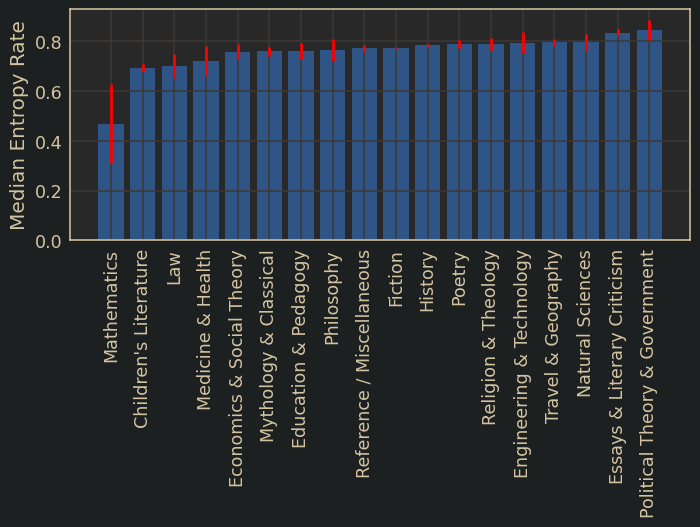

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Sort once using the central estimate
tf_s  = tf.sort_values('Median Entropy Rate')
tfl_s = tfl.loc[tf_s.index]
tfu_s = tfu.loc[tf_s.index]

x = np.arange(len(tf_s))
y = tf_s['Median Entropy Rate'].values

# Asymmetric errors
yerr = np.vstack([
    y - tfl_s['Median Entropy Rate'].values,   # lower
    tfu_s['Median Entropy Rate'].values - y    # upper
])

plt.figure(figsize=(8, 3))
ax = plt.gca()

# --- bars ---
ax.bar(
    x,
    y,
    width=0.8,
    alpha=0.6,
    edgecolor='none'
)

# --- error bars on top ---
ax.errorbar(
    x,
    y,
    yerr=yerr,
    fmt='none',
    ecolor='red',
    elinewidth=2,
    capsize=2,
    zorder=3
)

ax.set_xticks(x)
ax.set_xticklabels(tf_s.index, rotation=90)
ax.set_ylabel("Median Entropy Rate")

plt.tight_layout()
plt.show()
